# COVIDx implementation in Pytorch

In this notebook, we attempt to implement the [COVID-Net](https://github.com/lindawangg/COVID-Net) implementation in `Pytorch` and using the `Fast.ai` library. The network is trained to classify between `COVID`, `Pneumonia` and `normal`. 

In [1]:
import pandas as pd
import numpy as np
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from model_utils import custom_path_load, custom_path_save

# Data

We use two different datasets:

* https://github.com/ieee8023/covid-chestxray-dataset, containing 99 COVID, 17 bacterial and 11 viral chest x-ray images. 

*  https://www.kaggle.com/c/rsna-pneumonia-detection-challenge containing 1345 viral and 2530 bacterial images.  

Images have to be preprocessed a-priori using this attached [noteboook](./data_discovery.ipynb).

Processed images are stored in `data/COVIDx`.  We import the training and testing `Dataframes` to select the correspondent labels. 

In [2]:
train_path = 'data/COVIDx/train'
df_train = pd.read_pickle('covidX_train.pkl')
df_test = pd.read_pickle('covidX_train.pkl')
df_train.head()

,name,label
0,data/COVIDx/train/auntminnie-a-2020_01_28_23_5...,covid
1,data/COVIDx/train/auntminnie-b-2020_01_28_23_5...,covid
2,data/COVIDx/train/auntminnie-c-2020_01_28_23_5...,covid
3,data/COVIDx/train/auntminnie-d-2020_01_28_23_5...,covid
4,data/COVIDx/train/nejmc2001573_f1a.png,covid


In [3]:
data = ImageDataBunch.from_df(path='.', 
                              df=df_train,
                              valid_pct=0.25,
                              test=None,
                              ds_tfms=get_transforms(), 
                              bs=8, 
                              size=512, 
                              num_workers=8).normalize(imagenet_stats)

#show size of our datasets
print("TRAIN:", len(data.train_ds),
      "VALIDATION:", len(data.valid_ds))


TRAIN: 12507 VALIDATION: 4169


Inspect different cases: 

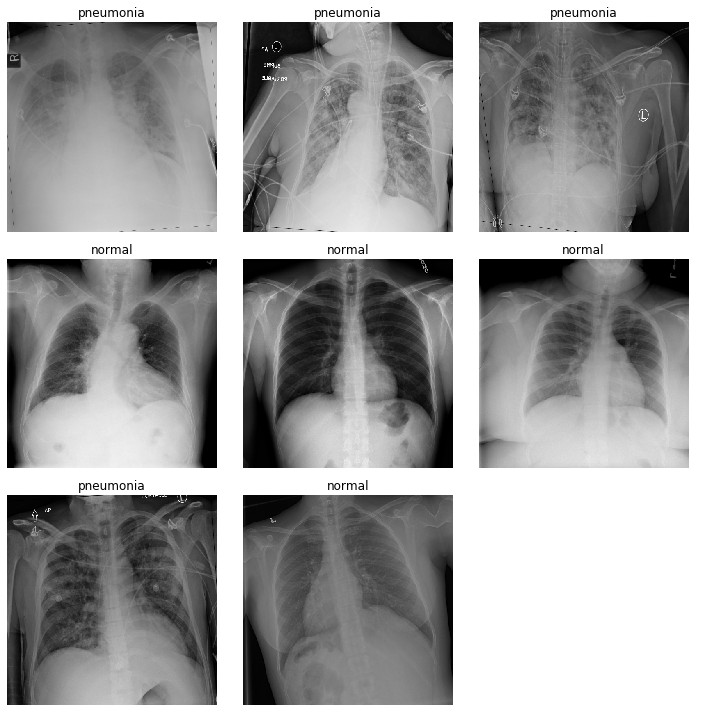

In [4]:
data.show_batch(rows=3, figsize=(10,10))

We define the model name, which will be use to save intermediate steps. We define specific callbacks to save and load already trained models. 

In [5]:
model_name = 'covidx_test'

model_path = os.path.join('models', model_name)

# create the models folder
if os.path.exists('models') is False:
    os.mkdir('models')

# create the current model folder
if os.path.exists(model_path) is False:
    os.mkdir(model_path)
   
def custom_path_save(self, 
                     name:PathOrStr, 
                     path='models', 
                     return_path:bool=False, 
                     with_opt:bool=True):
    '''
    Save model and optimizer state (if `with_opt`) 
    with `name` to `self.model_dir`."
    '''
    if path == '': 
        path = self.path/self.model_dir/f'{name}.pth'
    else: 
        path = f'{path}/{name}.pth'
    if not with_opt: 
        state = get_model(self.model).state_dict()
    else: 
        state = {'model': get_model(self.model).state_dict(), 'opt':self.opt.state_dict()}
    torch.save(state, path)
    
    if return_path: 
        return path

def custom_path_load(self, 
                     name:PathOrStr, 
                     path='models', 
                     device:torch.device=None, 
                     strict:bool=True, 
                     with_opt:bool=None,
                     purge=False):
    """
    Load model and optimizer state (if `with_opt`) `name` 
    from `self.model_dir` using `device`."

    """
    if device is None: 
        device = self.data.device
    if path=='': 
        path = self.path/self.model_dir/f'{name}.pth'
    else: 
        path = f'{path}/{name}.pth'
    
    state = torch.load(path, map_location=device) 
    if set(state.keys()) == {'model', 'opt'}:
        get_model(self.model).load_state_dict(state['model'], strict=strict)
        if ifnone(with_opt,True):
            if not hasattr(self, 'opt'): 
                opt = self.create_opt(defaults.lr, self.wd)
            try:    
                self.opt.load_state_dict(state['opt'])
            except: 
                pass
    else:
        if with_opt: 
            warn("Saved filed doesn't contain an optimizer state.")
        get_model(self.model).load_state_dict(state, strict=strict)
    return self

NameError: name 'model_name' is not defined

# Model configuration

Using a `resnet50` model. The model is `unfreezed` by default, resulting in `25M` training parameters. 

In [7]:
precision = Precision(average='macro')
AUC = AUROC()

# define model 
learn = cnn_learner(data, models.resnet50, metrics=(accuracy, precision, error_rate, AUC)) 
learn.unfreeze()


In [ ]:
## add a summmary of the model if necessary
learn.summary()

# Model training

Train 2 epochs and see how to update the learning rate. The model is trained using the `one cycle` policy. This allows us to easily train a network using [Leslie Smith's](https://arxiv.org/pdf/1803.09820.pdf) 1 cycle policy. Also look at [here](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html) based on this [paper](https://arxiv.org/abs/1506.01186).

To use the 1 cycle policy we will need an optimum learning rate. We can find this learning rate by using a learning rate finder which can be called by using `lr_finder`. It will do a mock training by going over a large range of learning rates, then plot them against the losses. We will pick a value a bit before the minimum, where the loss still improves. 

In [10]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,precision,error_rate,auroc,time
0,0.483723,0.281030,0.902135,0.601919,0.097865,0.036531,04:42
1,0.307864,0.192872,0.928040,0.952607,0.071960,0.019687,04:38


epoch,train_loss,valid_loss,accuracy,precision,error_rate,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


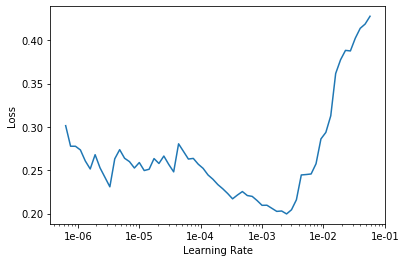

In [15]:
learn.lr_find()
learn.recorder.plot()

Compare `lr_find` util with the helper funcion `find_best_lr`


## Stage 1

In [ ]:
# partial traning step 
stage = 1

# load last model
#previous_stage = stage - 1
#learn.load(os.path.join(model_name, 'stage' + str(previous_stage)))
#learn.unfreeze()

# fit the model
learn.fit_one_cycle(10, max_lr=slice(1e-04, 1e-02))
learn.save(os.path.join(model_name, 'stage' + str(stage)))

# confusion matrix after partial training
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

epoch,train_loss,valid_loss,accuracy,precision,error_rate,auroc,time
0,0.195442,1.857965,0.941953,0.742282,0.058047,0.028317,04:36
1,0.225169,0.160758,0.943152,0.961988,0.056848,0.017967,04:38
2,0.309809,0.186814,0.941473,0.909847,0.058527,0.021059,04:38
3,0.377969,0.952241,0.925402,0.699285,0.074598,0.043810,04:38


## Stage 2

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# partial traning step 
stage = 2

# fit the model
learn.fit_one_cycle(10, max_lr=slice(1e-5, 1e-3))
learn.save(os.path.join(model_name, 'stage' + str(stage)))

# confusion matrix after partial training
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# confusion matrix after partial training
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Stage 3

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# partial traning step 
stage = 3

# load last model
#previous_stage = stage - 1
#learn.load(os.path.join(model_name, 'stage' + str(previous_stage)))
#learn.unfreeze()

# fit the model
learn.fit_one_cycle(10, max_lr=slice(1e-04, 5e-02))
learn.save(os.path.join(model_name, 'stage' + str(stage)))

# confusion matrix after partial training
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# confusion matrix after partial training
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# partial traning step 
stage = 6

# fit the model
#learn.fit_one_cycle(20, max_lr=slice(1e-6, 5e-05/6))
learn.fit_one_cycle(50)

learn.save(os.path.join(model_name, 'stage' + str(stage)))

# confusion matrix after partial training
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Predictions on Test Set

In [ ]:
TH = 0.5
test_path = 'data/test'
test_files = os.listdir(test_path)
images={filename:open_image(os.path.join(test_path, filename)) for filename in test_files}

# find labels
labels = [filename.find('covid') >= 0 for filename in test_files]
        
# evaluate results
results = {}
predictions = []
TP, FP = 0, 0
for f, l in zip(test_files, labels): 
    # check that filename is a COVID
    pred = learn.predict(images[f])
    i = 0 if pred[2][0] > TH else 1
    results[f] = classes[i] 
    predictions.append(i == 0)


final_df=pd.DataFrame.from_dict(results, orient='index')

predictions = np.array(predictions)
labels = np.array(labels)

# area under the curve
fpr, tpr, thresholds = roc_curve(labels, predictions)
print('ROC CURVE', auc(fpr, tpr))

cm = confusion_matrix(labels, predictions, labels = [True, False])
ax = plt.subplot()
sns.set_color_codes("pastel")
sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu")
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['COVID', 'Other']); ax.yaxis.set_ticklabels(['COVID', 'Other']);


In [ ]:
final_df

1_neg.png (Category normal, tensor(1), tensor([2.6336e-04, 9.0002e-01, 9.9716e-02]))
4_neg.png (Category normal, tensor(1), tensor([2.9572e-05, 9.3393e-01, 6.6039e-02]))
3_pos.png (Category normal, tensor(1), tensor([0.0025, 0.6434, 0.3541]))
2_neg.png (Category normal, tensor(1), tensor([1.8529e-04, 9.1179e-01, 8.8020e-02]))
1_pos.png (Category normal, tensor(1), tensor([6.0183e-04, 8.1980e-01, 1.7960e-01]))
3_neg.png (Category normal, tensor(1), tensor([6.1316e-05, 9.4110e-01, 5.8841e-02]))
2_pos.png (Category normal, tensor(1), tensor([0.0013, 0.7865, 0.2122]))
5_pos.png (Category normal, tensor(1), tensor([0.0043, 0.7988, 0.1969]))
4_pos.png (Category pneumonia, tensor(2), tensor([0.0813, 0.0609, 0.8578]))
5_neg.png (Category normal, tensor(1), tensor([7.0726e-04, 7.6960e-01, 2.2970e-01]))
ROC CURVE 0.5


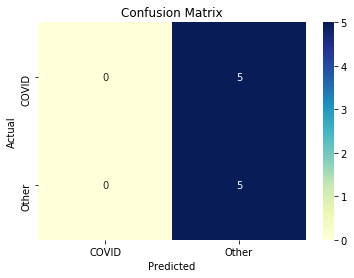

In [17]:
def convert_to_rgb(input_scan):
    if np.ndim(input_scan) == 2:
        input_scan = color.gray2rgb(input_scan)
    return input_scan

trueta_data_path = '/home/sergivalverde/DATA/COVID/COVID_HJT/images'
classes = ['covid', 'pneumonia', 'normal']
TH = 0.6
test_path = trueta_data_path
test_files = os.listdir(test_path)
images={filename:open_image(os.path.join(test_path, filename)) for filename in test_files}

# find labels
labels = [filename.find('pos') >= 0 for filename in test_files]
        
# evaluate results
results = {}
predictions = []
TP, FP = 0, 0
for f, l in zip(test_files, labels): 
    # check that filename is a COVID
    # pred = learn.predict(images[f])
    pred = learn.predict(convert_to_rgb(images[f]))
    print(f, pred)
    i = 0 if pred[2][0] > TH else 1
    results[f] = classes[i] 
    predictions.append(i == 0)


final_df=pd.DataFrame.from_dict(results, orient='index')

predictions = np.array(predictions)
labels = np.array(labels)

# area under the curve
fpr, tpr, thresholds = roc_curve(labels, predictions)
print('ROC CURVE', auc(fpr, tpr))

cm = confusion_matrix(labels, predictions, labels = [True, False])
ax = plt.subplot()
sns.set_color_codes("pastel")
sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu")
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['COVID', 'Other']); ax.yaxis.set_ticklabels(['COVID', 'Other']);

,0
1_neg.png,pneumonia
4_neg.png,pneumonia
3_pos.png,pneumonia
2_neg.png,pneumonia
1_pos.png,pneumonia
3_neg.png,pneumonia
2_pos.png,pneumonia
5_pos.png,pneumonia
4_pos.png,pneumonia
5_neg.png,pneumonia
